In [2]:
%load_ext autoreload
%autoreload 2
from newton import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer
import torch
from matplotlib import pyplot as plt

Link to newton.py in Github: https://github.com/jjr2024/github_jjr2024.github.io/blob/main/posts/newton-method/newton.py

## Introduction

In this blog post, I implement Newton's method, an optimizer technique that's an alternative to standard gradient descent. I run three experiments and find that Newton's method works best with low numbers of observations, high noise, and relatively low alphas (learning rates). Then I consider the computational cost of Newton's method vs. gradient descent and consider the impact of $p$, the number of features, on the comparison between the two methods. 

## Part A: Implement NewtonOptimizer

In this section, we define functions that we will use in our experiments. classification_data generates data for a classication problem: n_points controls the number of observations generated. Noise determines the difficulty of the problem. p_dims controls the number of features.

Train() is a function to train our LR model. We can control the maximum number of iterations (max_iterations) and the learning rate (a).

plot_perceptron_data and draw_line allow us to plot our data and our weight vector respectively to visualize our results.

In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

In [4]:
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss_vec = []

def train(X, y, max_iterations = 1000, a = 0.1):
    for _ in range(max_iterations):
        loss = LR.loss(X, y) 
        loss_vec.append(loss)
        opt.step(X, y, a)

In [5]:
def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")


def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

## Part B: Perform Experiments

### Experiment 1: Appropriate Alpha -> Converge to Correct Weight Vector

In the below code, we generate our classification data and calculate the loss vector when we use our Newton optimizer. The last item in the loss vector is near-zero.

In [6]:
LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss_vec = []

X, y = classification_data(n_points = 100, noise = 0.1, p_dims = 2)

train(X,y,1000,a=0.9)

print("Last Loss: " + str(loss_vec[len(loss_vec)-1]))

Last Loss: tensor(6.9629e-05)


In the below code, we save the loss vector we just computed into loss_vec2 and then compute, on the same classification data, the loss vector when we use standard gradient descent. Then we visualize both loss vectors.

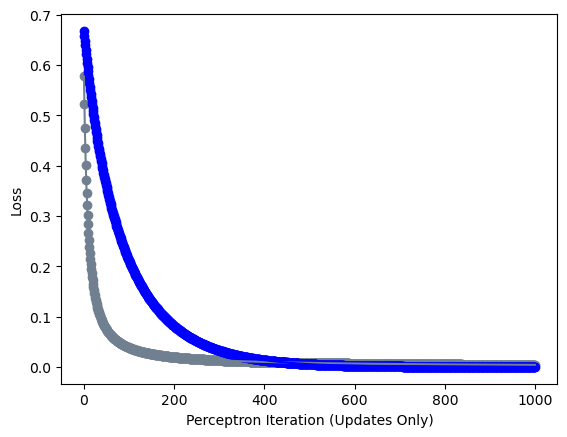

In [7]:
LR2 = LR
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec2 = loss_vec
loss_vec = []

#Standard gradient descent
for _ in range(1000):
    loss = LR.loss(X, y) 
    loss_vec.append(loss)
    opt.step(X, y, 0.9, 0.0)

plt.plot(loss_vec, color = "slategrey")
plt.plot(loss_vec2, color = "blue")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec2)), loss_vec2, color = "blue")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "Loss")

There are two key takeaways for the above graph of the loss vectors. 

First, we see that with alpha = 0.9, we eventually converge to a weight vector that produces a near-zero loss. Second, while the blue line (loss vector with Newton's Method) and the grey line (loss vector with standard gradient descent) have marked differences in early iterations, they eventually converge to a zero/near-zero loss.

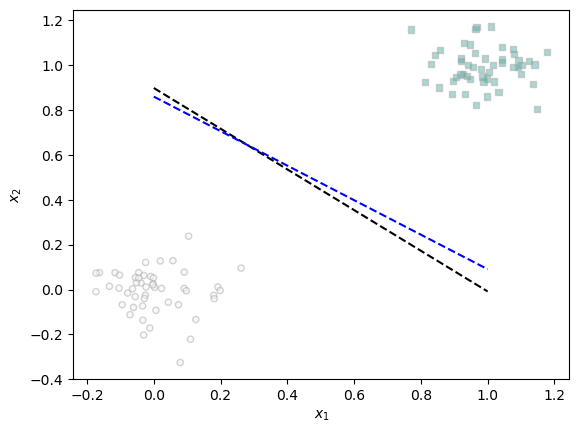

In [8]:
fig, ax = plt.subplots(1, 1)
plot_perceptron_data(X, y, ax)

draw_line(LR.w, 0, 1, ax, color = "black", linestyle = "dashed", label = "weight vector w")
draw_line(LR2.w, 0, 1, ax, color = "blue", linestyle = "dashed", label = "weight vector w")


We see above that standard gradient descent (black line) and Newton's method (blue line) have converged to very similar weight vectors. Both successfully separate our data into two categories.

### Experiment 2: Faster Convergence

Below, we run an experiment comparing standard gradient descent to the Newton's method in a context in which the latter has far faster convergence than the former. We set the number of observations to be very low (6) and the noise to be high (1).

In [9]:
X, y = classification_data(n_points = 6, noise = 1, p_dims = 2)

LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss_vec = []

max_iterations = 100
train(X,y,max_iterations,a=0.5)
loss_vec2 = loss_vec
LR2 = LR
print("Last Loss: " + str(loss_vec[len(loss_vec)-1]))

Last Loss: tensor(nan)


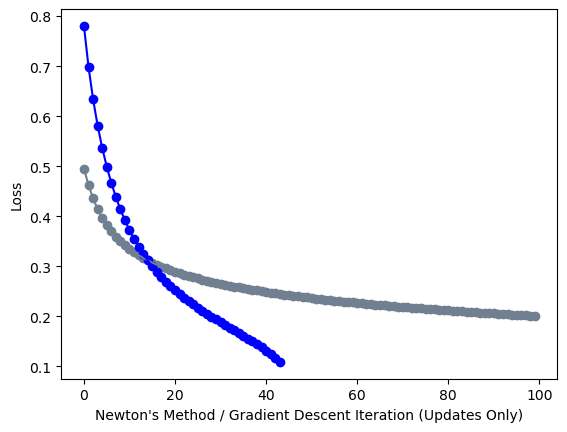

In [10]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec = []

#Standard gradient descent
for _ in range(max_iterations):
    loss = LR.loss(X, y) 
    loss_vec.append(loss)
    opt.step(X, y, 0.5, 0.0)

plt.plot(loss_vec, color = "slategrey")
plt.plot(loss_vec2, color = "blue")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec2)), loss_vec2, color = "blue")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "Loss")

Newton's method (blue line) converges far faster than standard gradient descent (grey line) when we have a very small number of data points and very high noise.

### Experiment 3: Failure to Converge

When alpha is too high, Newton's method fails to converge. In the below experiment, we create classification data with just 6 observations and set alpha = 15.

In [11]:
X, y = classification_data(n_points = 6, noise = 0.3, p_dims = 2)

LR = LogisticRegression() 
opt = NewtonOptimizer(LR)

loss_vec = []
alpha = 15

max_iterations = 100
for _ in range(max_iterations):
    loss = LR.loss(X, y) 
    loss_vec.append(loss)
    opt.step(X, y, alpha)
    

print("Matrix Inverse of Hessian: " + str(torch.linalg.inv(LR.hessian(X))))
print("Final Weights: " + str(LR.w))
print("Sigmoid(Scores): " + str(torch.sigmoid(LR.score(X))))
print("Log of One Less Sigmoid(Scores): " + str(torch.log(1 - torch.sigmoid(LR.score(X)))))
print("Last Loss: " + str(loss_vec[len(loss_vec)-1]))

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Iteration (Updates Only)", ylabel = "Loss")

_LinAlgError: linalg.inv: The diagonal element 1 is zero, the inversion could not be completed because the input matrix is singular.

With a high alpha relative to the number of datapoints, we get a strange loss vector and fail to converge. Above the chart is a series of print statements illustrating the problem. Our matrix inverse of the hessian ends up with values with extremely high absolute values because, multiplied by a high alpha, these values are embedded into the weights, which become increasingly large with each iteration. 

The weights are enormous, leading to extremely high scores, which translate into extremely negative values when we calculate the log of (1 - sigmoid(scores)). Those extremely negative values are treated by Python as negative infinity. By attempting to run calculations with these -inf values, we end up with NaNs.

## Part C: Operation Counting

### Problem

We are given the following:

* Computational units for each calculation
    * $L = c$
    * $\nabla L = 2c$
    * $Hessian = pc$
    * Invert a $p \times p$ matrix $= k_1p^\gamma$
    * Newton's method matrix-vector multiplication $= k_2p^2$
* Newton's method converges in $t_{nm}$ steps
* Gradient descent converges in $t_{gd}$ steps

We want to know how much smaller $t_{nm}$ needs to be than $t_{gd}$ for Newton's method to require fewer computational units to complete. We also want to know if using Newton's method ever pays off if $p$ is very large.

### Solution

First we set up a very abstract equation. Then we unravel the abstracted components of the equation.

1. Total computational cost of Newton's Method $=$ Total computational cost of gradient descent

For both sides of the equation, total computational cost = number of iterations (i.e., steps) times cost per iteration. 

2. $t_{nm} (c + 2c + pc + k_1p^\gamma + k_2p^2) = t_{gd} (c + 2c)$

3. $t_{nm} (3c + pc + k_1p^\gamma + k_2p^2) = t_{gd} (3c)$

4. $t_{nm} = t_{gd}*\frac{3c}{3c + pc + k_1p^\gamma + k_2p^2}$

With this equation, we know $t_{nm}$ must be $\frac{3c}{3c + pc + k_1p^\gamma + k_2p^2}$ of $t_{gd}$ for the computational costs to be *equal*. So $t_{nm}$ needs to be less than $\frac{3c}{3c + pc + k_1p^\gamma + k_2p^2}$ of $t_{gd}$ for Newton's method to be computationally cheaper than gradient descent.

The fraction shows that as p increases in size, the denominator of the right-hand-side fraction in step 4 increases. So the entire fraction shrinks in value. In other words, $t_{nm}$ must become an even smaller percentage of $t_{gd}$. Therefore, when $p$ becomes very large, it seems unlikely that using Newton's method will pay off.

## Part D: Writing

In this post, I found Newton's method was a computationally expensive but faster (in some cases) alternative to gradient descent. The number of observations, the difficulty of the classification problem (noise), and the learning rate all impacted the relative performance of Newton's method vs. gradient descent.

I continued to grapple with linear algebra and programming implementations of it in this post. Implementing Newton's method wasn't painless, but it went about as smoothly as implementing logistic regression. The similarity of this post with perceptron and logistic regression implementation helped significantly in making that happen. I gained more familiarity with analyzing the components of my model via the analysis in experiment 3. It helped significantly with my understanding of this model to break down, step-by-step, why the loss became NaN. 